In [1]:
import typing as tp

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn

sns.set(font_scale=1.4, palette='Set2')

## Исследование простой модели (50 баллов)

Это последний ноутбук в данном домашнем задании. Здесь вы исследуете влияние величины линейного слоя, инициализации и разных функций активации на обучение простой двухслойной модели. В качестве данных будет использоваться синтетическая выборка соответствующая примеру на лекции.

В данном ноутбуке **можно и нужно пользоваться PyTorch**. Все эксперименты будут вычислительно простыми, поэтому CUDA здесь не понадобится.

### 1. Реализация

Рассмотрим функцию с лекции:
$$f(x) = 0.2 + 1.4 x^2 + 0.3\sin(15x) + 0.1\cos(50x)$$
Будем приближать эту функции на отрезке $[0, 1]$ двухслойной нейронной сетью. 
* Первый слой будет содержать обучаемые веса и смещения. А также некоторую функцию активации $\sigma(x)$.
* Второй слой будет содержать только обучаемые веса (без смещения), а функция активации будет тождественной.

Если в качестве $\sigma(x)$ взять функцию индикатора, то поулчится нейронная сеть точь в точь такая же как на лекции.

Начнем с простого. Реализуйте заданную функцию.

In [2]:
def function(x: torch.Tensor):
    """
    Функция f(x).
    """
    
    return 0.2 + 1.4 * (x ** 2) + 0.3 * torch.sin(15 * x) + 0.1 * torch.cos(50 * x)

In [3]:
assert torch.allclose(function(torch.tensor(0)), torch.tensor(0.3), 1e-4)
assert torch.allclose(function(torch.tensor(1)), torch.tensor(1.8916), 1e-4)
assert torch.allclose(function(torch.tensor(0.5)), torch.tensor(0.9305), 1e-4)

Реализуйте модель двухслойной нейронной сети как в описании.

In [4]:
class MyModel(torch.nn.Module):
    """
    Двухслойная нейронная сеть.

    Параметры:
    * n_hidden - количество нейронов на первом слое;
    * activation - функция активации на первом слое.

    """

    def __init__(
            self, n_hidden: int, 
            activation: tp.Callable[[torch.Tensor], torch.Tensor]):
        super(MyModel, self).__init__()

        self.l1 = nn.Linear(1, n_hidden)

        self.l2 = nn.Linear(n_hidden, 1)
        self.l2.bias.data = torch.zeros_like(self.l2.bias.data)
        self.l2.bias.requires_grad = False

        self.activation = activation


    
    def forward(self, x):
        out = self.l1(x)
        out = self.activation(out)
        out = self.l2(out)
        return out

Сгенерируете значения $x$ с помощью равномерной сетки с шагом 0.01 на отрезке $[0, 1]$. Также посчитайте соответсв. значения $f(x)$.

In [5]:
x = torch.linspace(0, 1, 101, dtype=torch.float32).unsqueeze(1)
y_true = function(x)

In [6]:
assert x.shape == y_true.shape == (101, 1)

Напишите функцию для обучения сети. В данном случае, мы будем подавать в сеть всю выборку сразу, поэтому нет необходимости по ней итерерироваться. По ходу обучения будут сохраняться статистики `loss` и `grad_norm` (см. функцию  `calc_grad_norm`). Обе статистики представляют из себя скаляры, поэтому при сохранении используйте метод тензора `item`.

In [49]:
def calc_grad_norm(model):
    """
    Считает 2-ю норму градиента по всем параметрам для нашей модели.
    """
    grad_sum = model.l1.weight.grad.data.norm(2) ** 2
    grad_sum += model.l1.bias.grad.data.norm(2) ** 2
    grad_sum += model.l2.weight.grad.data.norm(2) ** 2
    grad_norm = torch.sqrt(grad_sum)
    return grad_norm

In [11]:
def train(model, optimizer, criterion, x, y, n_epochs, track_grad_norm=False):
    """
    Цикл обучения нейронной сети.

    Параметры:
    * model - модель;
    * optimizer - оптимизатор;
    * critetion - функция ошибки;
    * x - входные данные;
    * y - выходные данные;
    * n_epochs - количество эпох обучения;
    * track_grad_norm - сохранять ли норму градиента.
    """

    # история обучения
    history = {'loss': []}
    if track_grad_norm:
        history['grad_norm']  = []

    # вводим в привычку
    model.train()

    # цикл обучения
    for i in range(n_epochs):

        loss = mse(model(x), y_true)
        loss.backward()

        if track_grad_norm:
            grad_norm = calc_grad_norm(model)
            history['grad_norm'].append(grad_norm.item())

        optimizer.step()
        optimizer.zero_grad()    
        history['loss'].append(loss.item())

    return history

Напишите функцию для получения предсказания. Воспользуйтесь конструкцией, котрая позволяет не считать градиенты при прогоне модели.

In [12]:
def eval(model, x):
    """
    Предскзание модели.

    Параметры:
    * model - модель;
    * x - входные данные.
    """

    # вводим в привычку
    model.eval()

    y_pred = model(x)

    return y_pred

В качестве лосса и метрики будем использовать MSE.

In [13]:
mse = torch.nn.MSELoss()

### 2. Эксперименты

Для начала в качестве функции активации $\sigma(x)$ возьмем индикатор $I\{x > 0\}$ как на лекции. 

In [14]:
def indicator(x, threshold=0):
    return (x > threshold).to(torch.float32)

Инициализируйте модель. Сохраните значения весов модели. Сделайте одну итерацию обучения (одну эпоху). В качестве оптимизатора исопльзуйте `SGD`. Сравните новые веса модели со старыми. Объясните результат.

In [51]:
model = MyModel(n_hidden=5, activation=indicator)

In [52]:
w1_init = model.l1.weight.detach().clone()
b1_init = model.l1.bias.detach().clone()
w2_init = model.l2.weight.detach().clone()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
train(model, optimizer, mse, x, y_true, 1)

w1_new = model.l1.weight.detach().clone()
b1_new = model.l1.bias.detach().clone()
w2_new = model.l2.weight.detach().clone()

torch.allclose(w1_init, w1_new), torch.allclose(b1_init, b1_new), torch.allclose(w2_init, w2_new)

(True, True, False)

**Ответ.** От индикаторной функции производная не берется, поэтому веса никак не поменялись.

Положим `n_hidden=10`. Запустите инициализацию модели 5 раз. Постройте графики изменения лосса при обучении для каждой модели. Также постройте графики предсказания модели и сравните их с $f(x)$. Поясните результат.

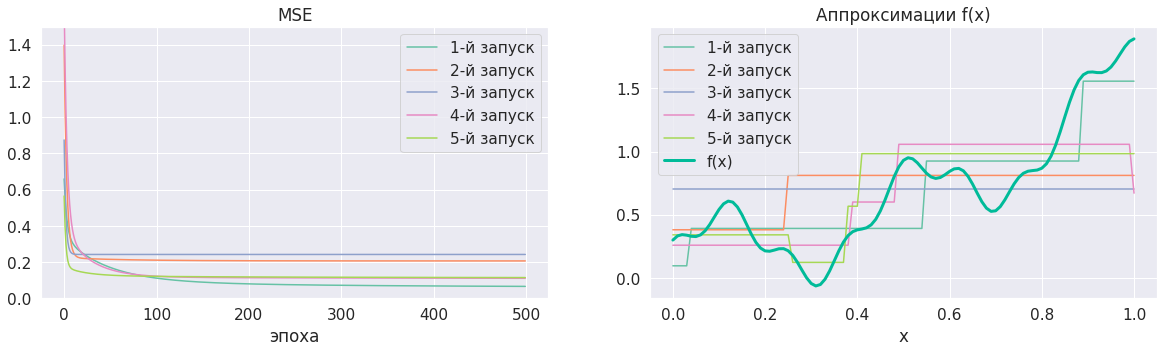

In [35]:
n_hidden = 10
iters = 5
epochs = 500

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
for i in range(iters):
    model = MyModel(n_hidden=n_hidden, activation=indicator)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
    loss_history = train(model, optimizer, mse, x, y_true, epochs)['loss']
    y_pred = eval(model, x)
    
    axs[0].plot(loss_history, label=f'{i + 1}-й запуск')
    axs[1].plot(x.ravel().detach().numpy(), y_pred.ravel().detach().numpy(), label=f'{i + 1}-й запуск')

axs[1].plot(x.ravel(), y_true.ravel(), label='f(x)', color='green', lw=3)

axs[0].set_xlabel('эпоха')
axs[1].set_xlabel('x')
axs[0].legend()
axs[1].legend()
axs[0].set_title('MSE')
axs[1].set_title('Аппроксимации f(x)')
axs[0].set_ylim(0, 1.5);

**Ответ.** Так как сначала инициализация случайная, то модели довольно сильно отличаются между собой.

Исследуйте то, как обучается модель в зависимости от ширины первого слоя (ширина = кол-во нейронов). Рассмотрите значения 5, 10, 20, 50, 100.  Теперь будем запускать инициализацию по 100 раз. Не беспокойтесь, считатется довольно шустро. Для каждой ширины слоя, постройте графики зависимости функции ошибки от эпохи обучения. Отобразите итговое среднее значение MSE. Также постройте график среднего предсказания с предсказтельным интервалом ширины $2\sigma$ (здесь корень из дисперсии), сравните его с $f(x)$. Сделайте выводы.

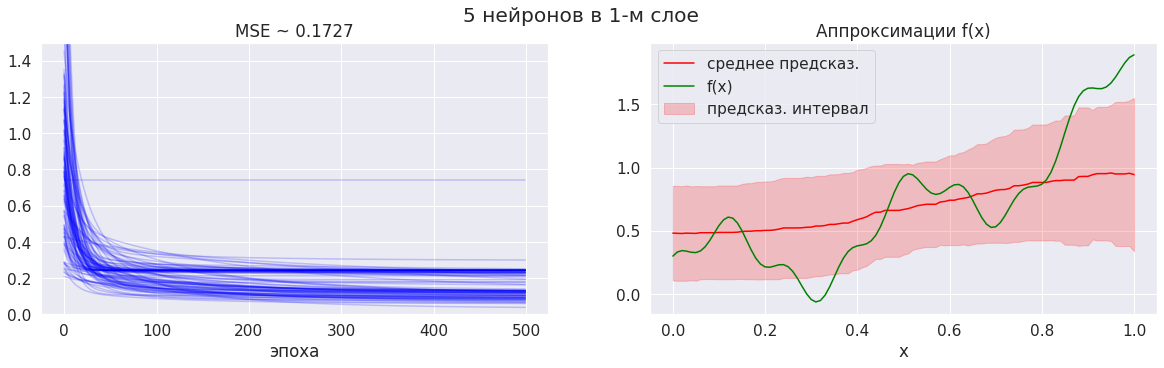

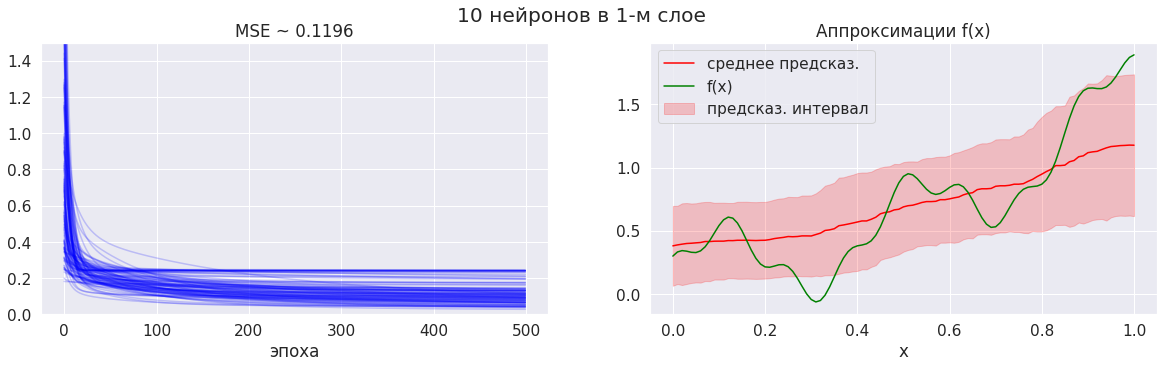

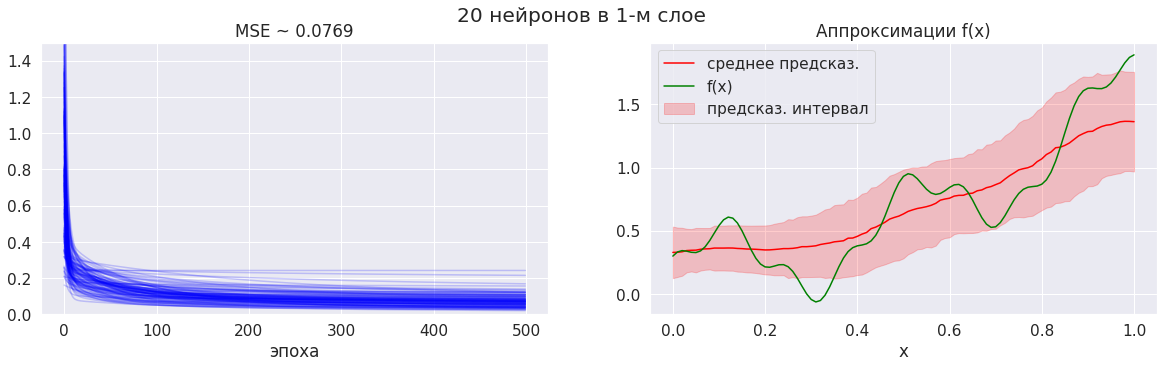

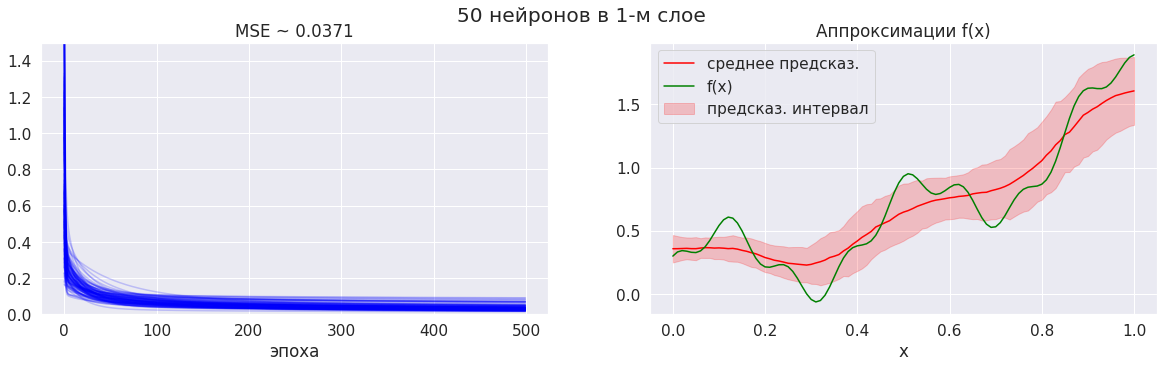

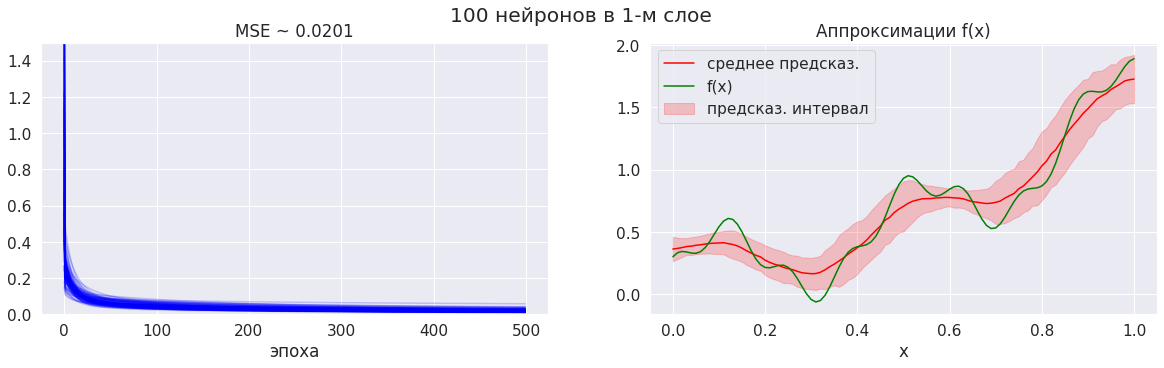

In [47]:
iters = 100

for n_hidden in [5, 10, 20, 50, 100]:
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    y_pred_all = []
    mse_all = []

    for i in range(iters):
        model = MyModel(n_hidden=n_hidden, activation=indicator)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        loss_history = train(model, optimizer, mse, x, y_true, epochs)['loss']
        axs[0].plot(loss_history, color='blue', alpha=0.2)
        y_pred = eval(model, x)
        mse_all.append(mse(y_pred, y_true))
        y_pred_all.append(y_pred.ravel().detach())

    y_pred_mean = torch.stack(y_pred_all).mean(dim=0)
    y_pred_std = torch.stack(y_pred_all).std(dim=0)
    axs[1].plot(x, y_pred_mean, color='red', label='среднее предсказ.')
    axs[1].fill_between(
        x.ravel(), y_pred_mean - 2 * y_pred_std, y_pred_mean + 2 * y_pred_std, 
        alpha=0.2, color='red', label='предсказ. интервал')
    axs[1].plot(x.ravel().detach().numpy(), y_true.ravel().detach().numpy(), label='f(x)', color='green')

    axs[0].set_xlabel('эпоха')
    axs[1].set_xlabel('x')
    axs[1].legend()
    axs[0].set_title(f'MSE ~ {torch.mean(torch.tensor(mse_all)):.4f}')
    axs[1].set_title('Аппроксимации f(x)')
    axs[0].set_ylim(0, 1.5)
    fig.suptitle(f'{n_hidden} нейронов в 1-м слое');

**Ответ.** Из графиков видно, что чем больше число нейронов в слое, тем меньше средняя ошибка и тем точнее аппроксимация функции f(x) и меньше предсказательный интервал.

Повторите то же самое для функции активации ReLU. При этом для каждого значения количества нейронов на первом слое постройте графики нормы градиентов. Сделайте выводы.

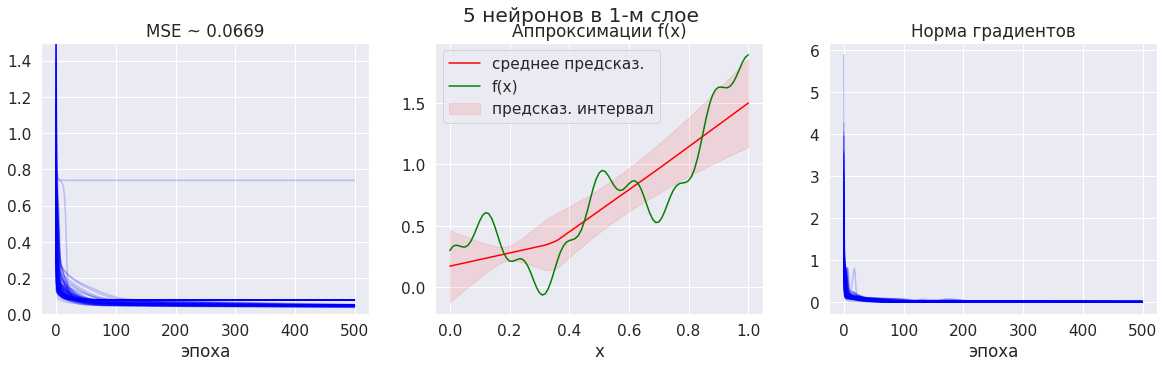

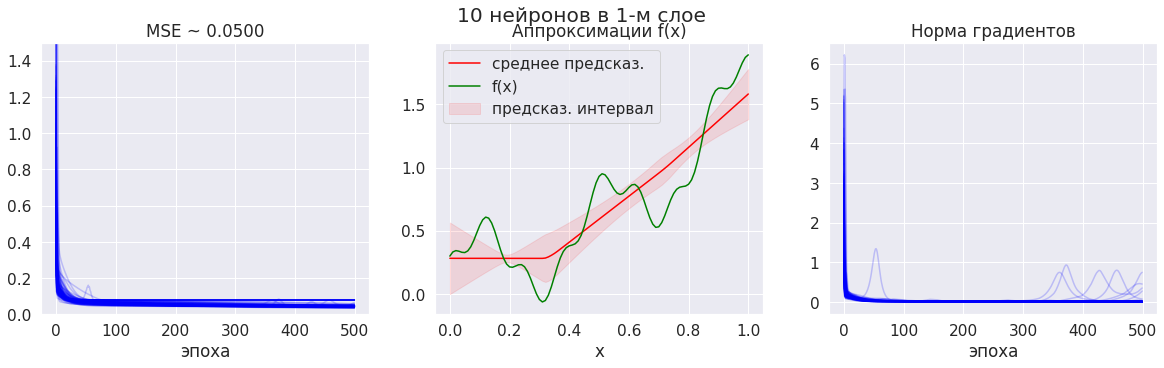

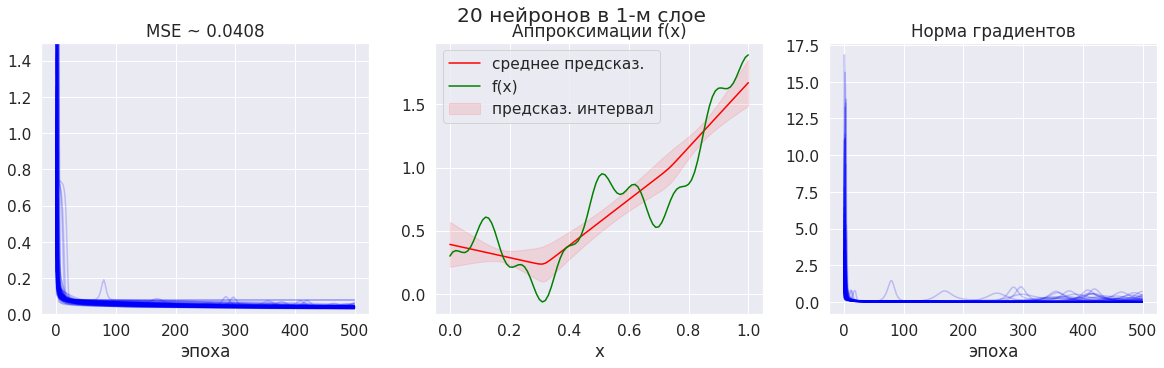

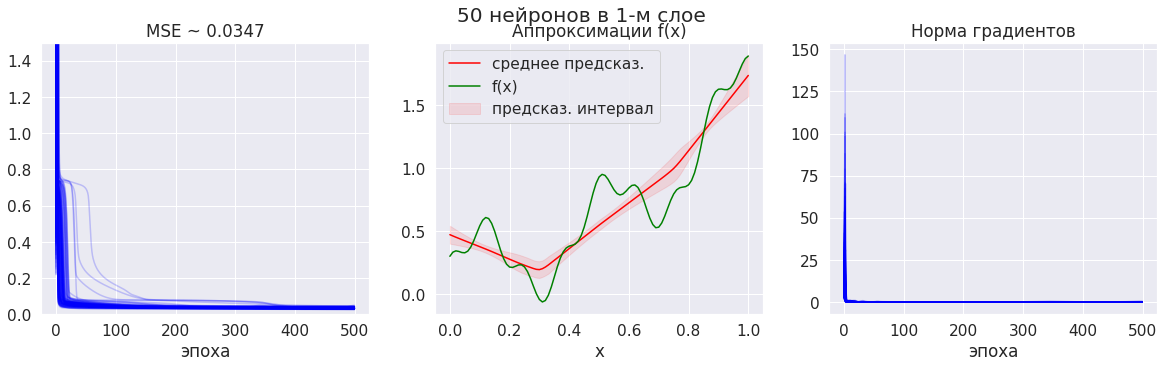

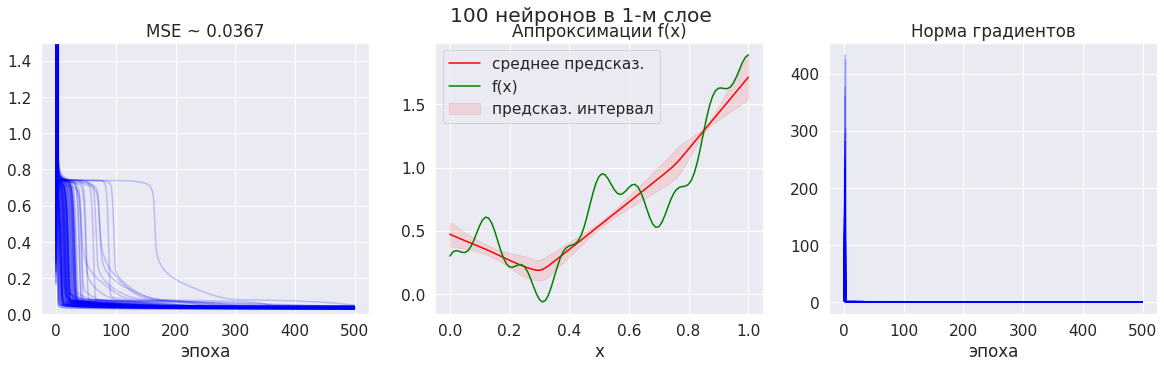

In [50]:
iters = 100

for n_hidden in (5, 10, 20, 50, 100):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    y_pred_all = []
    mse_all = []

    for i in range(iters):
        model = MyModel(n_hidden, activation=torch.nn.ReLU())
        optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
        history = train(model, optimizer, mse, x, y_true, epochs, track_grad_norm=True)
        loss_history = history['loss']
        grad_norm_history = history['grad_norm']
        axs[0].plot(loss_history, color='blue', alpha=0.2)
        axs[2].plot(grad_norm_history, color='blue', alpha=0.2)
        y_pred = eval(model, x)
        mse_all.append(mse(y_pred, y_true))
        y_pred_all.append(y_pred.ravel().detach())

    y_pred_mean = torch.stack(y_pred_all).mean(dim=0)
    y_pred_std = torch.stack(y_pred_all).std(dim=0)
    axs[1].plot(x, y_pred_mean, color='red', label='среднее предсказ.')
    axs[1].fill_between(
        x.ravel(), y_pred_mean - 2 * y_pred_std, y_pred_mean + 2 * y_pred_std, 
        alpha=0.1, color='red', label='предсказ. интервал')
    axs[1].plot(x.ravel(), y_true.ravel(), label='f(x)', color='green')

    axs[0].set_xlabel('эпоха')
    axs[1].set_xlabel('x')
    axs[1].legend()
    axs[0].set_title(f'MSE ~ {torch.mean(torch.tensor(mse_all)):.4f}')
    axs[1].set_title('Аппроксимации f(x)')
    axs[2].set_title('Норма градиентов')
    axs[2].set_xlabel('эпоха')
    axs[0].set_ylim(0, 1.5)
    
    fig.suptitle(f'{n_hidden} нейронов в 1-м слое');

**Ответ.** Из графиков видно, что с данной функцией активации (RELU) мы хуже аппроксимируем нашу функцию, чем в предыдущем случае.

---
**Вывод**

В данной задаче мы аппроксимировали функцию f(x) с пмомщью двухслойной нейронной сети. Посмотрели на зависимост ошибки от запусков функции обучения. Затем посмотрели на зависимость среднего предсказания и предсказательного интервала от числа нейронов в слое и функции активации. Заметили, что чем больше нейронов, тем лучше приближается функция, что и логично, также заметили, что индикаторная функция активации сработала лучше, чем функция активации RELU.